### Behavioral modelling

#### Assumptions:

1. experienced utility is some function of displayed reward magnitude: 
    - simple model: $u(x) = x$ 
    - complex model: $u(x) = x^{\delta} \quad if \quad x>0$ or $u(x) = -\gamma |x|^{\delta} \quad if \quad x>0$
2. values (reflecting beliefs about probability) are learned with simple delta learning rule (TD model):
    - $V(a_t)=V(a_{t-1})+ \alpha [R-V(a_{t-i})]$
3. choice probabilites are probabilistic functions of expected utilities:
    - degenerate model: $p(a)=\frac{EV(a)}{EV(a)+EV(b)}$ (parsimoneous approach introduced by *Summerfield et al. 2011*)
    - full softmax model: $p(a)=\frac{\exp(\beta EV(a))}{\exp(\beta EV(a)) + \exp(\beta EV(b))}$

#### Free parameters:

- $\alpha \in [0, 1]$: learning rate (modelling learning rate above half would result in model selecting previously rewarded / not punished option which is not realistic 
- $\gamma \in [0, \infty]$: loss aversion parameter
- $\delta \in [0, 1]$: risk aversion parameter
- $\beta \in [0, \infty]$: inverse temperature for softmax function

#### Model variations:

- model 1: (k=1 parameter) simple utility model, degenerate model for choice probabilities
- model 2: (k=2 parameters) simple utility model, full softmax model
- model 3: (k=4 parameters) complex utility model, full softmax model


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json

plt.style.use('seaborn-ticks')

In [3]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/behavioral/behavioral_data_clean_all.npy"
beh_meta_path = beh_path.replace('npy', 'json')

# Load behavioral data
beh = np.load(beh_path)
with open(beh_meta_path, 'r') as f:
    meta = json.loads(f.read())
    
print("Shape of beh array:", beh.shape)
print("Conditions", [(i, cond) for i, cond in enumerate(meta['dim2'])])
print("Columns:", [(i, col) for i, col in enumerate(meta['dim4'])])

n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


In [4]:
def estimate_values(beh, meta, subject, condition, alpha):
    '''Implements TD learning model on experienced probabilistic outcomes.
    
    Args:
        beh (np.array): aggregated behavioral responses
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index
        alpha (float): learning rate 
        
    Returns:
        val (np.array): reflects algorithm trialwise beliefs about 
            probabilities that box will be rewarded / punished
    '''
    
    val = np.zeros((beh.shape[2], 2))
    val[0] = [.5, .5] # Initial beliefs (agnostic)

    rewarded = beh[subject, condition, :, meta['dim4'].index('rwd')][:-1]
    
    for trial, rwd in enumerate(rewarded):
        val[trial+1, 1] = val[trial, 1] + alpha * ((rwd + 1)/2 - val[trial, 1])
        val[trial+1, 0] = val[trial, 0] + alpha * ((-rwd + 1)/2 - val[trial, 0])    

    return val

def estimate_utilities(beh, meta, subject, condition, gamma=1, delta=1):                                               
    '''Implements function converting reward magnitude to experienced utility.
    
    Args:
        beh (np.array): aggregated behavioral responses
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index
        gamma (float): loss aversion parameter
        delta: (float): risk aversion parameter
        
    Returns:
        util (np.array): reflects algorithm trialwise estimates of utility 
            for both left and right boxes
    '''
    util = np.zeros((beh.shape[2], 2))
    
    if condition == meta['dim2'].index('pun'): 
        factor = (-1) * gamma
    else:
        factor = 1
        
    util[:, 0] = factor * np.power(
        np.abs(beh[subject, condition, :, meta['dim4'].index('magn_left')]), 
        delta
    )
    util[:, 1] = factor * np.power(
        np.abs(beh[subject, condition, :, meta['dim4'].index('magn_right')]), 
        delta
    )

    return util

def estimate_choice_probability(val, util, kind='simple', theta=None):
    '''Implements softmax decision rule reflecting choice probabilities
    
    Args:
        val (np.array): trialwise beliefs about probabilities that box will 
            be rewarded / punished
        util (np.array): trialwise estimates of utility for both boxes
        kind (str): either 'simple' or 'softmax' for two different models
        theta (float): inverse temperature for softmax function
        
    Returns:
        p (np.array): trialwise choice probabilities
    '''

    # Calculate expected value for both options
    ev = np.multiply(util, val)
    
    if kind == 'simple':
        p = ev / np.sum(ev, axis=1)[:, np.newaxis]
        if np.sum(ev) < 0: 
            p = np.fliplr(p)
        
    elif kind == 'softmax':
        p = np.exp(theta * ev) / np.sum(np.exp(theta * ev), axis=1)[:, np.newaxis]

    return p

def g_square(beh, meta, subject, condition, p):
    '''Calculate badness-of-fit quality measure. G-square is inversely 
    related to log likelyhood.
    
    Args:
        beh (np.array): aggregated behavioral responses
        meta (dict): description of beh array coding
        subject (int): subject index
        condition (int): task condition index
        p (np.array): trialwise choice probabilities
    
    Returns:
        (float): g-square badness-of-fit
    '''

    ll = 0 
    responses = beh[subject, condition, :, meta['dim4'].index('response')]
    
    for trial, response in enumerate(responses):
        if response == -1:
            ll += np.log(p[trial, 0])
        elif response == 1:
            ll += np.log(p[trial, 1])

    return (-2) * ll

### Behavioral Models #######################################################
def model1(beh, meta, subject, condition, alpha):
    '''Simple one-parameter model with variable learning rate.'''
    
    val = estimate_values(beh, meta, subject, condition, alpha)
    util = estimate_utilities(beh, meta, subject, condition)
    p = estimate_choice_probability(val, util, kind='simple')
    
    return p
    
    
def model2(beh, meta, subject, condition, alpha, theta):
    '''Two-parameter model  with variable learning rate and inverse T.'''
    
    val = estimate_values(beh, meta, subject, condition, alpha)
    util = estimate_utilities(beh, meta, subject, condition)
    p = estimate_choice_probability(val, util, kind='softmax', theta=theta)
    
    return p

def model3(beh, meta, subject, condition, alpha, theta, gamma, delta):
    '''Four-parameter model.
    
    Args:
        alpha (float): learning rate
        theta (float): inverse softmax temperature
        gamma (float): loss aversion
        delta (float): risk aversion 
    '''
    
    val = estimate_values(beh, meta, subject, condition, alpha)
    util = estimate_utilities(beh, meta, subject, condition, gamma, delta)
    p = estimate_choice_probability(val, util, kind='softmax', theta=theta)
    
    return p

### Show example model fit for models 1 and 2
Models are fitted to subject responses using $G^2$ which is a measure of badness-of-fit derived from log likelyhood. In this section model 1 and 2 are fitted for all possible parameters sampled from parameter space. Both task conditions are fitted separately for single subject. Finally, $G^2$  function is visualised in the parameter space.

/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log


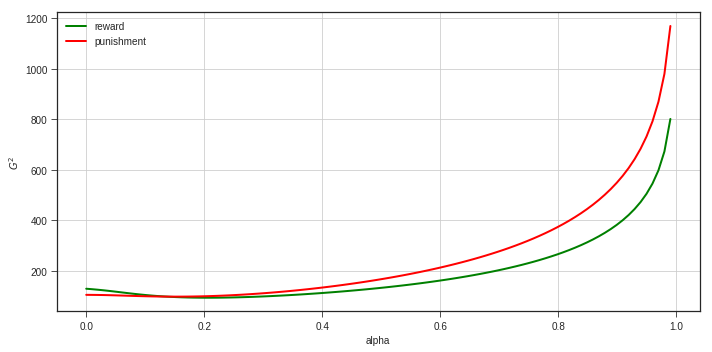

In [12]:
N_grid = 100
subject = 1

### Model 1 #################################################################
alpha = np.linspace(0, 1, N_grid)

fit1 = np.zeros((2, N_grid))
for i, a in enumerate(alpha):
    fit1[0, i] = g_square(beh, meta, subject, 0, 
                          model1(beh, meta, subject, 0, a))
    fit1[1, i] = g_square(beh, meta, subject, 1, 
                          model1(beh, meta, subject, 1, a))
    
    
# Figure 1
fig1, ax = plt.subplots(facecolor='w', figsize=(10, 5))
ax.plot(alpha, fit1[0,:], linewidth=2, color='g', label='reward')
ax.plot(alpha, fit1[1,:], linewidth=2, color='r', label='punishment')

ax.set_ylabel('$G^2$')
ax.set_xlabel('alpha')
ax.legend()
ax.grid()

plt.tight_layout()

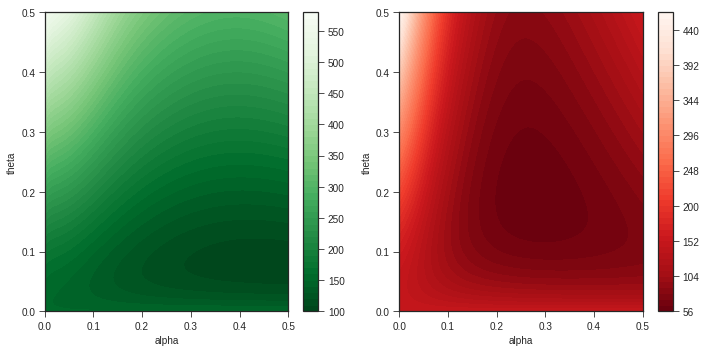

In [15]:
N_grid = 100
subject = 27

## Model 2 #################################################################
alpha = np.linspace(0, .5, N_grid)
theta = np.linspace(0, .5, N_grid)

av, tv = np.meshgrid(alpha, theta)

fit2 = np.zeros((2, N_grid, N_grid))
for i, a in enumerate(alpha):
    for j, t in enumerate(theta):
        fit2[0, i, j] = g_square(beh, meta, subject, 0,
                                 model2(beh, meta, subject, 0, a, t))
        fit2[1, i, j] = g_square(beh, meta, subject, 1,
                                 model2(beh, meta, subject, 1, a, t))

# Figure 2
fig2, (ax2r, ax2p) = plt.subplots(nrows=1, ncols=2, 
                                  facecolor='w', figsize=(10, 5))
im2r = ax2r.contourf(alpha, theta, fit2[0].T, levels=50, cmap='Greens_r')
im2p = ax2p.contourf(alpha, theta, fit2[1].T, levels=50, cmap='Reds_r')

ax2r.set_xlabel('alpha')
ax2r.set_ylabel('theta')
ax2p.set_xlabel('alpha')
ax2p.set_ylabel('theta')

fig2.colorbar(im2r, ax=ax2r)
fig2.colorbar(im2p, ax=ax2p)

plt.tight_layout()

### Model fitting for single subject responses
In this section model parameters are optimized for explaining subject responses. Behavioral responsed are pooled across both task conditions.  

In [17]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [149]:
bounds1 = Bounds([0], [1])
x0 = np.array([.5])

def cost_model1(x):
    '''Optimization function for model 1.'''
    global subject
    g_rew = g_square(beh, meta, subject, 0, model1(beh, meta, subject, 0, x))
#     g_pun = g_square(beh, meta, subject, 1, model1(beh, meta, subject, 1, x))
    return g_rew  #+ g_pun

alpha_fit = np.zeros((n_subjects, 2)) # store results

for subject in range(n_subjects):

    # print(f'Finding parameter for subject {subject}...')
    res = minimize(cost_model1, x0, method='SLSQP', bounds=bounds1)
    alpha_fit[subject, 0] = res['x']
    alpha_fit[subject, 1] = res['fun']

/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log
/home/kmb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log


array([0.26229634, 0.20677297, 0.83553207, 0.42850959, 0.73502176,
       0.34870703, 0.03382461, 0.65725947, 0.30605566, 0.58283041,
       0.37873599, 0.24451058, 0.08309575, 0.32090706, 0.41262368,
       0.28827709, 0.31376484, 0.24357873, 0.70485236, 0.55799692,
       0.42051165, 0.12743767, 0.64647315, 0.45237454, 0.44834319,
       0.64341453, 0.6168717 , 0.52436319, 0.32583531, 0.65404977,
       0.36540772, 0.39284934])

array([[1.        , 0.98369974],
       [0.98369974, 1.        ]])

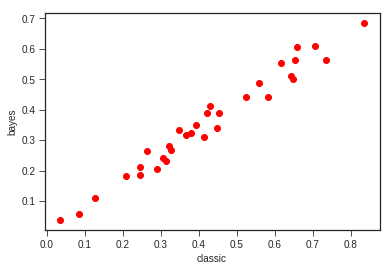

In [155]:
classic = np.array([0.26229634, 0.20677297, 0.83553207, 0.42850959, 0.73502176,
       0.34870703, 0.03382461, 0.65725947, 0.30605566, 0.58283041,
       0.37873599, 0.24451058, 0.08309575, 0.32090706, 0.41262368,
       0.28827709, 0.31376484, 0.24357873, 0.70485236, 0.55799692,
       0.42051165, 0.12743767, 0.64647315, 0.45237454, 0.44834319,
       0.64341453, 0.6168717 , 0.52436319, 0.32583531, 0.65404977,
       0.36540772, 0.39284934])

bayes = np.array([0.26555101, 0.18188305, 0.68540723, 0.41283568, 0.56205493,
       0.33277677, 0.03646573, 0.60736784, 0.24180079, 0.4420432 ,
       0.32256171, 0.18492777, 0.05911576, 0.28068696, 0.31012604,
       0.20609922, 0.23082238, 0.21194786, 0.6096009 , 0.48789681,
       0.38794743, 0.11148475, 0.50130744, 0.39023806, 0.33860929,
       0.51078252, 0.55261129, 0.44028743, 0.26917858, 0.56469864,
       0.31766604, 0.34845983])

plt.plot(classic, bayes, 'ro', label='alpha')
plt.xlabel('classic')
plt.ylabel('bayes')

### Model comparison for single subject
In this section three models are compared with respect to their Akaike Information Criterion (AIC score). AIC enables comparision of models with different number of free parameters. AIC is defined as:
$$AIC = G^2 + 2k$$ 

In [22]:
subject = 1

results = {}
results['model1'] = {'k': 1, 'g_square': None, 'x': None}
results['model2'] = {'k': 2, 'g_square': None, 'x': None}
results['model3'] = {'k': 4, 'g_square': None, 'x': None}

### Model 1 #################################################################
bounds1 = Bounds([0], [1])

def cost_model1(x):
    '''Optimization function for model 1.'''
    g_rew = g_square(beh, meta, subject, 0, model1(beh, meta, subject, 0, x))
    g_pun = g_square(beh, meta, subject, 1, model1(beh, meta, subject, 1, x))
    return g_rew  + g_pun

x0 = np.array([.5])

res1 = minimize(cost_model1, x0, method='SLSQP', bounds=bounds1)
results['model1']['g_square'] = res1['fun']
results['model1']['x'] = res1['x']

### Model 2 #################################################################
bounds2 = Bounds([0, 0], [1, np.inf])

def cost_model2(x):
    '''Optimization function for model 2.'''
    g_rew = g_square(beh, meta, subject, 0, 
                     model2(beh, meta, subject, 0, x[0], x[1]))
    g_pun = g_square(beh, meta, subject, 1, 
                     model2(beh, meta, subject, 1, x[0], x[1]))
    return g_rew + g_pun

x0 = np.array([.5, 1])

res2 = minimize(cost_model2, x0, method='SLSQP', bounds=bounds2)    
results['model2']['g_square'] = res2['fun']
results['model2']['x'] = res2['x']

# ### Model 3 #################################################################
bounds3 = Bounds([0, 0, 0, 0], [1, np.inf, np.inf, 1])

def cost_model3(x):
    '''Optimization function for model 3.'''
    g_rew = g_square(beh, meta, subject, 0, 
                     model3(beh, meta, subject, 0, x[0], x[1], x[2], x[3]))
    g_pun = g_square(beh, meta, subject, 1, 
                     model3(beh, meta, subject, 1, x[0], x[1], x[2], x[3]))
    return g_rew + g_pun

x0 = np.array([.5, .5, 1, 1])

res3 = minimize(cost_model3, x0, method='SLSQP', bounds=bounds3)    
results['model3']['g_square'] = res3['fun'] 
results['model3']['x'] = res3['x']

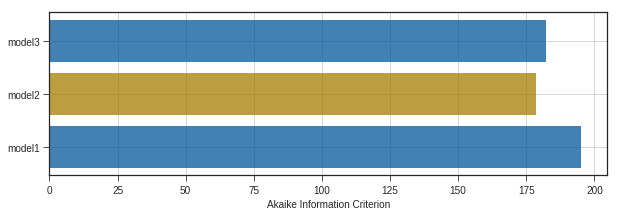

In [23]:
aic = np.zeros(3)

for i, model in enumerate(results):
    aic[i] = results[model]['g_square'] + 2*results[model]['k']

plt.style.use('seaborn-ticks')

fig, ax = plt.subplots(facecolor='w', figsize=(10, 3))

color = ['#01579B' for _ in range(3)]
color[np.argmin(aic)] = '#A67C00'
ax.barh(range(3), aic, color=color, alpha=.75)
ax.set_xlabel('Akaike Information Criterion')
ax.set_yticks(range(3))
ax.set_yticklabels(['model1', 'model2', 'model3'])
ax.grid()